# **Initialization** 

In [67]:
import pandas as pd
import numpy as np

### Control

In [68]:
# Paths
RAW_DATA_FOLDER = 'raw_data'
TARGET_FILE_PATH = 'unprocessed_data'

# Flow Controls
RELOAD_RAW_DATA = False

# System variables
STATE = 42
TEST_SET_FRACTION = 0.20
MISSING_VALUES_THRESHOLD = 0.50

# **Data Preparation**

### Merge raw data files

In [69]:
from raw_data_loader import load_raw_data

if (RELOAD_RAW_DATA):
    load_raw_data(RAW_DATA_FOLDER, TARGET_FILE_PATH)

### Preprocessing and Split

In [70]:
from preprocessing_depression import clean_and_preprocess_depression_data

dataset = pd.read_csv(TARGET_FILE_PATH + '/depression_data.csv')
X_train, X_test, y_train, y_test, y_embed_train, y_embed_test = clean_and_preprocess_depression_data(dataset, RAW_DATA_FOLDER, TEST_SET_FRACTION, STATE, MISSING_VALUES_THRESHOLD)

#TODO: Add insomnia part, and change variable names to have one for depression and one for insomnia

#TODO Fix issue with the time columns SLQ300/310/320/330

Dropped 142 columns with >50.0% missing values
Shape after dropping high-missing columns: (3333, 109)
Replaced 708 special code values with NaN
Replaced 186 special code values with NaN
Ordinal columns: 27
Nominal columns: 3
Binary columns: 2
Numerical columns: 74
Object columns (excluded): 3
Total columns identified: 109


c:\Users\irene\anaconda3\envs\eslEnv\lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['SLQ300' 'SLQ310' 'SLQ320' 'SLQ330']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\irene\anaconda3\envs\eslEnv\lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['SLQ300' 'SLQ310' 'SLQ320' 'SLQ330']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\irene\anaconda3\envs\eslEnv\lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['SLQ300' 'SLQ310' 'SLQ320' 'SLQ330']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [71]:
print(y_embed_train[:20])

      DPQ010  DPQ020  DPQ030  DPQ040  DPQ050  DPQ060  DPQ070  DPQ080  DPQ090
2230       0       0       0       1       0       0       0       0       0
3499       0       0       0       1       0       0       0       0       0
4042       1       1       1       1       1       0       0       0       0
3585       0       1       0       1       1       1       1       0       0
1903       0       0       0       1       0       0       1       0       0
2079       0       0       0       2       0       0       0       0       0
1116       1       1       0       1       1       1       2       1       0
3005       0       0       2       1       0       1       1       0       0
812        0       2       1       1       0       0       0       0       1
2584       1       1       1       1       0       1       0       0       0
883        3       3       3       3       1       1       0       0       0
2513       1       1       1       1       1       1       1       0       0

Class distribution:
depressed
0    3095
1     238
Name: count, dtype: int64

Class ratio: 7.690%


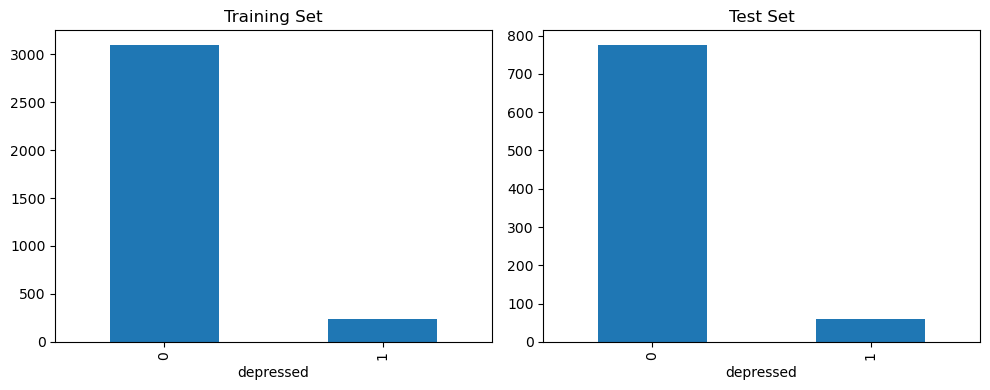

In [72]:
import matplotlib.pyplot as plt

# Check class distribution
print("Class distribution:")
print(y_train.value_counts())
print(f"\nClass ratio: {100*(y_train.value_counts()[1] / y_train.value_counts()[0]):.3f}%")

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
y_train.value_counts().plot(kind='bar', ax=ax[0], title='Training Set')
y_test.value_counts().plot(kind='bar', ax=ax[1], title='Test Set')
plt.tight_layout()
plt.show()

In [73]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

def resample_training_data(X_train, y_train, y_embed_train, sampling_strategy='auto', random_state=42):
    """
    Resample training data to address class imbalance.
    """
    X_columns = X_train.columns.tolist() if hasattr(X_train, 'columns') else None
    y_embed_columns = y_embed_train.columns.tolist() if hasattr(y_embed_train, 'columns') else None
    y_name = y_train.name if hasattr(y_train, 'name') else 'depressed'

    # Convert to numpy
    X = np.array(X_train) if hasattr(X_train, 'values') else X_train
    y = np.array(y_train).ravel() if hasattr(y_train, 'values') else np.array(y_train).ravel()
    y_embed = np.array(y_embed_train) if hasattr(y_embed_train, 'values') else y_embed_train

    # Combine X and and y_embed for resampling
    n_features = X.shape[1]
    X_combined = np.hstack([X, y_embed])

    # Apply SMOTE
    sampler = SMOTE(sampling_strategy=sampling_strategy, random_state=random_state)
    X_combined_resampled, _ = sampler.fit_resample(X_combined, y)

    X_resampled = X_combined_resampled[:, :n_features]
    y_embed_resampled = X_combined_resampled[:, n_features:]
    # Round embeddings to discrete values (0, 1, 2, 3)
    y_embed_resampled = np.clip(np.round(y_embed_resampled), 0, 3).astype(int)

    # Calculate y values based on DSM-V criteria
    core_criterion = (y_embed_resampled[:, 0] >= 2) | (y_embed_resampled[:, 1] >= 2)
    symptom_count = (y_embed_resampled >= 2).sum(axis=1)
    
    depression_criteria = core_criterion & (symptom_count >= 5)
    y_resampled = depression_criteria.astype(int)
    
    X_resampled = pd.DataFrame(X_resampled, columns=X_columns)
    y_resampled = pd.Series(y_resampled, name=y_name)
    y_embed_resampled = pd.DataFrame(y_embed_resampled, columns=y_embed_columns)

    return X_resampled, y_resampled, y_embed_resampled

In [ ]:
X_train_resampled, y_train_resampled, y_embed_train_resampled = resample_training_data(
    X_train, y_train, y_embed_train, random_state=STATE)

print(f"\nVerification after resampling:")
unique, counts = np.unique(y_train_resampled, return_counts=True)
print(f"  Classes: {unique}")
print(f"  Counts: {counts}")


Verification after resampling:
  Classes: [0 1]
  Counts: [3136 3054]


# **Models**

### Training Bayesian Models

In [75]:
from bayesian_models import *

train_binary_bayes(X_train, X_test, y_train, y_test)
train_multitarget_bayes(X_train, X_test, y_train, y_test, y_embed_train, y_embed_test)
train_bayes_with_embed(X_train, X_test, y_train, y_test, y_embed_train, y_embed_test)



 ######################################## Binary GaussianNB Model ########################################
F1 score: 0.2334384858044164
ROC-AUC: 0.728135593220339
              precision    recall  f1-score   support

           0       0.96      0.71      0.82       775
           1       0.14      0.63      0.23        59

    accuracy                           0.71       834
   macro avg       0.55      0.67      0.53       834
weighted avg       0.90      0.71      0.78       834

Confusion matrix:
 [[554 221]
 [ 22  37]]


 ######################################## Multitarget Bayesian Ridge Model ########################################
MSE per DPQ item: [0.6081899  0.55723907 0.83870486 0.6835447  0.69565646 0.62180295
 0.64496949 0.41919515 0.20707469]
Average MSE: 0.5862641415149625
F1 score: 0.3157894736842105
ROC-AUC: 0.5984691088026243
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       775
           1       0.71      0

### Training Random Forests

In [76]:
# Parameters
N_ESTIMATORS = 100

In [77]:
from forest_models import *

train_binary_forest(N_ESTIMATORS, STATE, X_train, X_test, y_train, y_test)
train_multitarget_forest(N_ESTIMATORS, STATE, X_train, X_test, y_train, y_test, y_embed_train, y_embed_test)
train_forest_with_embed_input(N_ESTIMATORS, STATE, X_train, X_test, y_train, y_test, y_embed_train, y_embed_test)



 ######################################## binary Forest  ########################################
F1 score: 0.03333333333333333
ROC-AUC: 0.8023728813559323
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       775
           1       1.00      0.02      0.03        59

    accuracy                           0.93       834
   macro avg       0.97      0.51      0.50       834
weighted avg       0.94      0.93      0.90       834

Confusion matrix:
 [[775   0]
 [ 58   1]]


 ######################################## Multitarget Forest  ########################################
MSE per DPQ item: [0.66152182 0.58451823 0.85873981 0.69939856 0.7436259  0.65868909
 0.67468957 0.45619149 0.2308952 ]
Average MSE: 0.6186966293631762
F1 score: 0.29213483146067415
ROC-AUC: 0.5992017495899399
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       775
           1       0.43      0.22      0.29      

### Training Logistic Models

In [78]:
# Parameters
MAX_ITERATIONS = 1000

In [79]:
from logistic_models import *

train_binary_logistic(MAX_ITERATIONS, STATE, X_train, X_test, y_train, y_test)
train_multitarget_logistic(MAX_ITERATIONS, STATE, X_train, X_test, y_train, y_test, y_embed_train, y_embed_test)
train_logistic_with_embed_input(MAX_ITERATIONS, STATE, X_train, X_test, y_train, y_test, y_embed_train, y_embed_test)



 ######################################## Binary Logistic Regression  ########################################
F1 score: 0.2918454935622318
ROC-AUC: 0.7994969928922908
              precision    recall  f1-score   support

           0       0.96      0.82      0.89       775
           1       0.20      0.58      0.29        59

    accuracy                           0.80       834
   macro avg       0.58      0.70      0.59       834
weighted avg       0.91      0.80      0.84       834

Confusion matrix:
 [[635 140]
 [ 25  34]]


 ######################################## Multitarget Logistic Regression ########################################
MSE per DPQ item: [2.441247   1.30815348 1.8117506  1.52398082 1.65467626 1.34772182
 1.47961631 1.98800959 1.5059952 ]
Average MSE: 1.673461231015188
F1 score: 0.26523297491039427
ROC-AUC: 0.6954948059048661
              precision    recall  f1-score   support

           0       0.96      0.76      0.85       775
           1       0.17   

### Train Split MLP

In [80]:
from split_model import train_split_model
import torch

torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_split_model( X_train, X_test, y_train, y_test, y_embed_train, y_embed_test )

TypeError: 'int' object is not callable

### Train Joint MLP

In [ ]:
from joint_model import train_joint_model

train_joint_model( X_train, X_test, y_train, y_test, y_embed_train, y_embed_test )